# Look-elsewhere effect

When searching for an excess (peak) in some phase-space which has an unknown location, one has to correct the local significance for the fact that one would have reported random peaks produced by chance in the entire phase-space if these peaks were as large as the observed one. The result is called global significance. It is possible to compute the global significance with Monte-Carlo simulation, but this is expensive.

Gross and Vitells give a recipe for a surprisingly simple approximate calculation of global significance, which in its simplest form requires no Monte-Carlo simulation. One merely has to scan over the phase-space and count the number of upcrossings of the local significance of a small threshold. The accuracy of the method can be improved by running a small number of simulations.

This notebook applies the results from these two papers to a simple toy example:

* E. Gross, O. Vitells, "Trial factors for the look elsewhere effect in high energy physics", Eur. Phys. J. C 70 (2010) 525
* O. Vitells and E. Gross, "Estimating the significance of a signal in a multi-dimensional search", Astropart. Phys. 35 (2011) 230, arXiv:1105.4355

We search for a resonance in a wide mass window. Let's assume that an experiment has found a peak in this window that does not correspond to a known particle. We now want to quantify the global significance of this peak. The model for the peak is a voigtian, which has two unknown parameters: the location of the peak, equal to the mass of the particle, and the width of the Cauchy distribution, related to the unknown life-time of the particle. The width of the Gaussian part of the voigtian is assumed to be known, since it corresponds to the resolution of the experiment.

In [50]:
from numba_stats import truncexpon, voigt
from scipy.stats import chi2, norm as scipy_norm
import numpy as np
from iminuit import Minuit
from iminuit.cost import ExtendedBinnedNLL
from matplotlib import pyplot as plt
from scipy.optimize import NonlinearConstraint
from jacobi import propagate
from resample.bootstrap import resample, variance
from skimage.measure import euler_number
from joblib import delayed, Parallel
from pathlib import Path
import pickle
import gzip
from rich.progress import Progress

## Before we start: technical obstacles and their solutions

### Numerical issues when converting between large sigmas and small probabilities

In the calculation, we evaluate the chi2 distribution in its upper tail (and the standard normal, where the same issue occurs). Computing the p-value as `1 - chi2(...).cdf(z ** 2)` becomes inaccurate when `z` is large. Instead, we use the survival function implemented in `scipy.stats`, which calculates `1 - cdf` accurately. Likewise, we use `chi2(...).isf` to compute the inverse of the survival function.

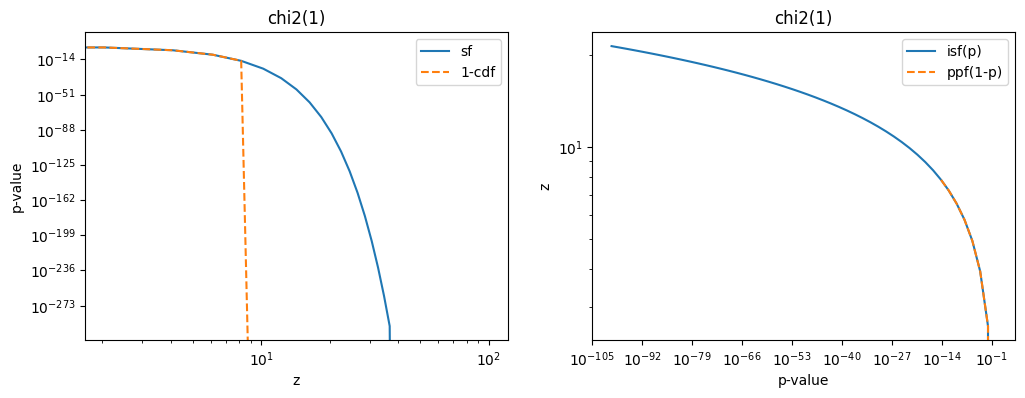

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.sca(ax[0])
z = np.linspace(0, 100)
plt.title("chi2(1)")
plt.plot(z, chi2(1).sf(z**2), label="sf")
plt.plot(z, 1 - chi2(1).cdf(z**2), label="1-cdf", ls="--")
plt.loglog()
plt.xlabel("z")
plt.ylabel("p-value")
plt.legend()

plt.sca(ax[1])
plt.title("chi2(1)")
p = np.geomspace(1, 1e-100)
plt.plot(p, chi2(1).isf(p) ** 0.5, label="isf(p)")
plt.plot(p, chi2(1).ppf(1 - p) ** 0.5, label="ppf(1-p)", ls="--")
plt.loglog()
plt.xlabel("p-value")
plt.ylabel("z")
plt.legend();

The same numerical issue also occurs when p-values are converted to sigmas using the integral of the upper tail of a standard normal distribution. The following two functions convert between p-values and z, the significance in units of standard deviation of a normal distribution. We will use them very often.

In [52]:
def z_to_pvalue(z):
    return scipy_norm.sf(z)


def pvalue_to_z(pvalue):
    return scipy_norm.isf(pvalue)

The quantity $q = z^2$ is chi2 distributed with one degree of freedom. We consider only a positive excess as evidence against the background-only hypothesis, but the chi2 distribution ignores the sign of the deviation. We can nevertheless obtain the same mapping between probabilities and sigmas if we take half of the p-value for the chi2 distribution. This identity will be important later.

In [53]:
from scipy.stats import norm

z = 5
q = z ** 2

norm().sf(z), 0.5 * chi2(1).sf(q)

(2.8665157187919333e-07, 2.8665157187919375e-07)

### Locally negative densities

In the scan over the parameter space, we need to fit the model `µ s + b`, where `µ` is the signal amplitude, `s` is the signal shape, and `b` is the background density. To avoid issues with Wilks' theorem, we allow the fit to find peaks with `µ < 0`, even though we do not consider these as evidence against the background-only hypothesis. This, however, also opens the possibility that the sum of signal and background densities can locally become negative during the numerical minimization process, which is forbidden, as densities cannot be negative. If this happens, the fit would likely fail.

To work around this, we first perform a standard minimization using iminuit using the MIGRAD algorithm, but if that fails, we call the scipy minimizers that support additional constrains that prevent the density from becoming locally negative. We prefer MIGRAD, however, because the scipy minimizer is slower. Having a fast and stable fit is useful, since we are going to fit millions of times, and it is important that the fit converges every time.

### Computing the test statistic $q$

The computation of global significance is based on the local test statistic $q$, which must be chi2 distributed. This test statistic can be computed in two ways, but the first way presented now is more accurate and is generally recommended.

The test statistic $q$ appears in the likelihood ratio test, in which the likelihood of the background only hypothesis, where the signal amplitude is zero, is compared to the likelihood of the alternative hypothesis where the amplitude is non-zero. According to Wilks' theorem, the quantity $q$ is asymptotically chi2 distributed with one degree of freedom, 
$$
q = -2 \ln\frac{\mathcal{L}(0, \theta, \hat \phi')}{\mathcal{L}(\hat \mu, \theta, \hat \phi)}\,,
$$
where $\mathcal{L}(\mu, \theta, \phi)$ is the likelihood for both hypotheses, $\hat \mu$ is the best-fit value of the signal amplitude, $\theta$ are any number of nuisance parameters fixed in the scan, and $\hat \phi$ and $\hat \phi'$ are best fit values of the parameters of the background model for the two hypotheses. These can take different values depending on whether $\mu$ is zero or not, hence they are distinguished as $\hat \phi$ and $\hat \phi'$.

Note that $q$ asymptotically follows a chi2 distribution with one degree of freedom for any lengths of the parameter vectors $\theta$ and $\phi$, since Wilks' theorem only counts the difference in the number of free parameters between both hypotheses. This difference is always 1.

The second asymptotically equivalent way to compute $q$ is to divide the signal amplitude by the signal uncertainty estimated by the fit, and to square the result:
$$
q = \left(\frac{\hat \mu}{\hat \sigma_\mu}\right)^2
$$
Note that $z = \hat \mu / \hat \sigma_\mu$ is also the local significance in units of sigmas. However, numerical studies showed that this way of calculating $q$ is less accurate and leads to deviations from the expected chi2 distribution in simulated experiments. The reason is that in practice the signal uncertainty is computed numerically from the second derivative of the log-likelihood, and is sometimes underestimated, leading to $q$ values that are too large.


## Construction of the dataset

We construct the toy distribution. It is a background-only sample from a truncated exponential distribution. We call this random sample "data", it shall represent the actual measurement which we scan over for a peak.

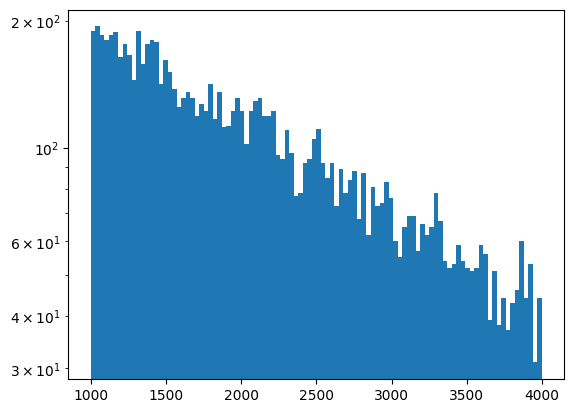

In [54]:
lambd_true = 2000
background_true = 10000

data = truncexpon.rvs(1000, 4000, 0, lambd_true, background_true, 1)
plt.hist(data, bins=100)
plt.semilogy();

## 1D case

We start with the 1D case. For this, we consider only the mass of the particle as unknown, but the width of the Cauchy distribution as known. We scan over the unknown mass and compute the local significance at each location. This requires fitting a signal + background model. We use iminuit and numba_stats, which works very well and is very fast, but other fitting frameworks can do the same job.

In case of `iminuit`, we use `Minuit.fval` to compute $q$ which returns the value $-2 \ln\mathcal{L}$ for the built-in cost function `ExtendedBinnedNLL`.

In [55]:
def model(xe, signal, mass, width, background, lambd):
    b = background * truncexpon.cdf(xe, 1000, 4000, 0, lambd)

    sigma_resolution = 50  # some fixed value

    # poor man's integration of voigt.pdf
    dx = np.diff(xe)
    ds = signal * voigt.pdf(xe[:-1] + 0.5 * dx, width, mass, sigma_resolution) * dx
    s = np.append(0, np.cumsum(ds))

    return s + b


def fit_background(mass):
    n, xe = np.histogram(mass, bins=100)
    c = ExtendedBinnedNLL(n, xe, model)
    minuit = Minuit(
        c, signal=0, mass=0, width=1, background=background_true, lambd=lambd_true
    )
    minuit.fixed["signal", "width", "mass"] = True
    minuit.limits["lambd", "background"] = (0, None)
    minuit.migrad()
    return minuit.fval, minuit


def fit(mass, m, w, chi2_background):
    n, xe = np.histogram(mass, bins=100)
    c = ExtendedBinnedNLL(n, xe, model)
    minuit = Minuit(
        c, signal=0, mass=m, width=w, background=background_true, lambd=lambd_true
    )
    minuit.fixed["width", "mass"] = True
    minuit.limits["lambd", "background"] = (0, None)
    minuit.migrad()
    # The pdf must not be negative. If MIGRAD fails, then usually because of that.
    # If that happens, we try again with with a constrained minimization,
    # see explaination above.
    if not minuit.valid:
        minuit.reset()
        minuit.scipy(
            constraints=[
                NonlinearConstraint(lambda *args: np.diff(model(xe, *args)), 0, np.inf)
            ]
        )
        if not minuit.valid:
            return np.nan, minuit

    # In theory, q is always positive, but it can take a tiny negative value in practice
    # due to numerical errors. We guard against that with the max function.
    q = max(chi2_background - minuit.fval, 0)

    # We want to return z instead of q, so we need to take the square root here. The
    # square-root of q is always positive, but we also want to know the sign of the
    # fitted amplitude for further analysis, so we copy it over from the signal.
    z = np.copysign(q ** 0.5, minuit.values["signal"])

    # This alternative calculation of z is more straight-forward but less accurate:
    # z = (minuit.values["signal"] / minuit.errors["signal"])
    return z, minuit


def z_scan(mass, m_grid, rw_grid):
    chi2_background = fit_background(mass)[0]
    X, Y = np.meshgrid(m_grid, rw_grid)
    fn = np.vectorize(lambda m, rw: fit(mass, m, m * rw, chi2_background)[0])
    Z = fn(X, Y).T
    return np.squeeze(Z)


m_grid = np.linspace(1200, 3800, 200)
# relative width of Cauchy part is fixed in 1D case, will be scanned over in 2D case
rw_grid = 0.05

z = z_scan(data, m_grid, rw_grid)

Let's plot the most significant peak candidate.

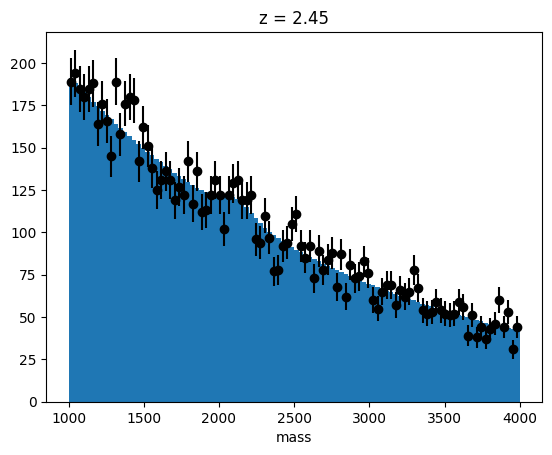

In [56]:
imax = np.argmax(z**2)
zmax, minuit = fit(
    data, m_grid[imax], rw_grid * m_grid[imax], fit_background(data)[0]
)
minuit.visualize()
plt.title(f"z = {zmax:.2f}")
plt.xlabel("mass");

It has a local significance of $z_\mathrm{local} = 2.45$. Next, we plot the $z$ values and the p-values computed from $q = z^2$ and a chi2 distribution with one degree of freedom. We are interested the excursion set, more specifically, how many connected stretches ("upcrossings") there are for which these p-values fall below threshold values computed from the one-sided standard normal distribution (these thresholds are given by the function `z_to_pvalue`). I emphasize that we compute the p-value from $q$ using the chi2(1) distribution, but for the thresholds we use `z_to_pvalue` which gives half of `chi2(1).sf(z ** 2)`.

This accounts for the fact that only consider positive $z$ as evidence against the background-only hypothesis. It also allows us to count the upcrossings at the lowest possible level of $0\sigma$, which is mapped to the threshold P=0.5. The upcrossings are the most frequent and have a small relative counting error. This nice trick is not documented in the papers, but described in a presentation by Eilam Gross given at the ATLAS Stat Forum, 3/2010.

z_local = 2.45 P_local = 0.007


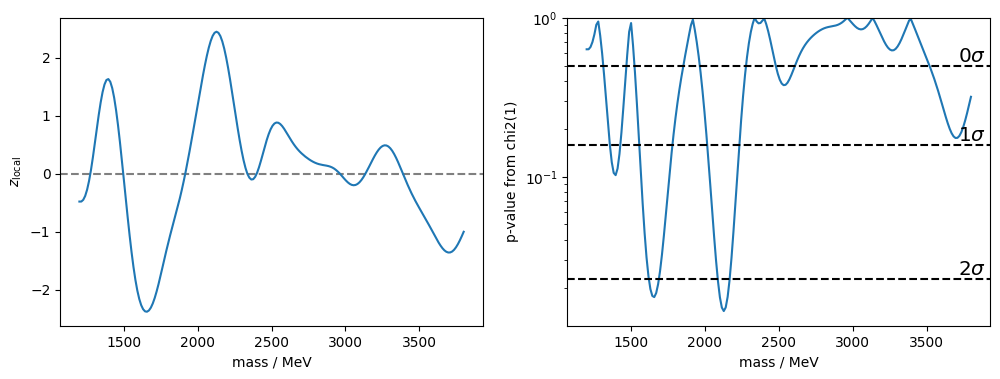

In [57]:
# p-value from chi2(1) for an excess in q=z^2
pvalue_q = chi2(1).sf(z ** 2)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.sca(ax[0])
plt.axhline(0, ls="--", color="0.5")
plt.xlabel("mass / MeV")
plt.ylabel(r"$z_\mathrm{local}$")
plt.plot(m_grid, z)
plt.sca(ax[1])
plt.plot(m_grid, pvalue_q)
plt.semilogy()
plt.ylim(None, 1)
for sigma in range(5):
    # for thresholds, we use z_to_pvalue, see text
    p = z_to_pvalue(sigma)
    if p > np.min(pvalue_q):
        plt.axhline(p, ls="--", color="k")
        plt.text(
            3900, p, f"${sigma}\sigma$", fontsize="x-large", va="bottom", ha="right"
        )
plt.ylabel("p-value from chi2(1)")
plt.xlabel("mass / MeV")

z_local = z[imax]
print(f"z_local = {z_local:.2f} P_local = {z_to_pvalue(z_local):.3f}")

The following functions compute the number of upcrossings, the global significance, and the global p-value from the local significance values.

In [58]:
def compute_p_global(z_local, z_threshold, n_upcrossings):
    u_local = z_local**2
    u_threshold = z_threshold**2
    phalf = 0.5 * chi2(1).sf(u_local)  # equal to p_local = z_to_pvalue(z_local)
    return phalf + n_upcrossings * np.exp(0.5 * (u_threshold - u_local))


def compute_z_global(z_local, z_threshold, n_upcrossings):
    return pvalue_to_z(compute_p_global(z_local, z_threshold, n_upcrossings))


def compute_number_of_upcrossings(z, z_threshold):
    # We use euler_number from scikit-image to compute the number of upcrossings.
    # It is designed for 2D data, but also works on 1D data.
    excursion_set = chi2(1).sf(z ** 2) < z_to_pvalue(z_threshold)
    excursion_set = np.atleast_2d(excursion_set)
    return euler_number(excursion_set)


z_threshold = 0  # chosen threshold for upcrossings in units of sigma
n_upcrossings = compute_number_of_upcrossings(z, z_threshold)
print(f"upcrossings = {n_upcrossings}")

# propagate uncertainty of n_upcrossing, which is a Poisson distributed number
z_global, z_global_cov = propagate(
    lambda n: compute_z_global(z_local, z_threshold, n), n_upcrossings, n_upcrossings
)

print(f"z_global = {z_global:.2f} ± {z_global_cov ** 0.5:.2f}")

upcrossings = 5
z_global = 0.66 ± 0.35


The uncertainty of the computed global significance is statistical: we replaced the expected number of upcrossings with an estimate based on the observed number of upcrossings in only one sample.

We can reduce this error to any desired value by running more simulations and computing the average of the number of upcrossings from these simulations. With 100 simulations, the error can be reduced by a factor of 10 to 0.02, which is already almost negligible. If we extrapolate a larger local significance, the error also becomes smaller.

We now confirm this calculation with a toy simulation, in which we repeatedly simulate independent experiments, do the local scan, and record the largest $q$ value found. This produces a sample of $q$ values.

In [59]:
# we cache this calculation, since it takes a while
cache_file = Path("q_samples.pkl.gz")

if cache_file.exists():
    with gzip.open(cache_file) as f:
        q = pickle.load(f)
else:
    q = []

    seeds = 10000

    @delayed
    def run(iseed):
        mass = truncexpon.rvs(1000, 4000, 0, lambd_true, background_true, iseed)
        z = z_scan(mass, m_grid, rw_grid)
        return np.max(z**2)

    with Progress() as progress:
        q = Parallel(n_jobs=8)(run(iseed) for iseed in progress.track(range(seeds)))
    q = np.array(q)

    with gzip.open(cache_file, "w") as f:
        pickle.dump(q, f)

# check that all fits converged properly
np.mean(np.isnan(q))

0.0

Here is the distribution of the test statistic $q$ over many independent experiments. For large $q$ values it becomes an exponential distribution, as predicted by the Gross & Vitells formula.

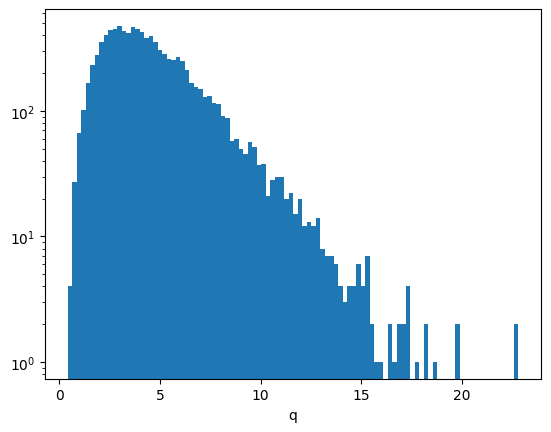

In [60]:
plt.hist(q, bins=100)
plt.semilogy()
plt.xlabel("q");

The global p-value is given by the fraction of $q$ values in simulated experiments which exceed the value found in the original data sample. We can further convert this probability into sigmas with our usual conversion formulas. The uncertainty is readily obtained with the bootstrap.

The simulation result is in agreement with the Gross & Vitells calculation.

In [61]:
p_global_sim = np.mean(q > z_local**2)
z_global_sim = pvalue_to_z(p_global_sim)

z_global_sim_cov = variance(lambda q: pvalue_to_z(np.mean(q > z_local**2)), q)
print(f"z_global_sim = {z_global_sim:.2f} +/- {z_global_sim_cov ** 0.5:.2f}")

z_global_sim = 0.73 +/- 0.01


Out of curiosity, let's plot the experiment with the largest $q$. It turns out to be a negative deviation.

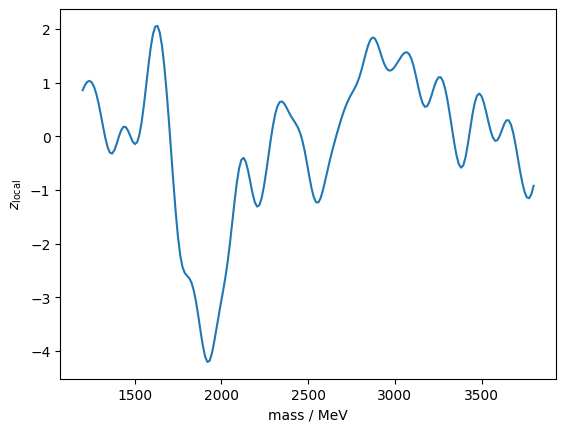

In [62]:
iseed = np.argmax(q)
mass = truncexpon.rvs(1000, 4000, 0, lambd_true, background_true, iseed)
z_m = []
for m in m_grid:
    z_m.append(fit(mass, m, rw_grid, fit_background(mass)[0]))
plt.plot(m_grid, [x[0] for x in z_m])
plt.ylabel("$z_\mathrm{local}$")
plt.xlabel("mass / MeV");

This is the corresponding fit of the maximum deviation:

In [63]:
z_m[np.argmax([x[0] ** 2 for x in z_m])][1]

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 93.4 (χ²/ndof = 1.0)       │              Nfcn = 51               │
│ EDM = 1.26e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ signal     │   -114    │    26     │            │            │         │         │       │
│ 1 │ mass       │  1.919e3  │  0.019e3  │            │            │         │         │  yes  │
│ 2 │ width      │  50.0e-3  │  0.5e-3   │            │            │         │         │  yes  │
│ 3 │ background │  10.12e3  │  0.10e3   │            │            │    0    │         │       │
│ 4 │ lambd      │  1.97e3   │  0.05e3   │            │            │    0    │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬────────────────────────────────────────────────────────┐
│            │     signal       mass      width background      lambd │
├────────────┼────────────────────────────────────────────────────────┤
│     signal │        655          0          0     -0.8e3      0.1e3 │
│       mass │          0          0          0          0          0 │
│      width │          0          0          0          0          0 │
│ background │     -0.8e3          0          0   1.09e+04     -0.1e3 │
│      lambd │      0.1e3          0          0     -0.1e3   2.22e+03 │
└────────────┴────────────────────────────────────────────────────────┘

To verify the result of the Gross & Vitells formula more broadly, we compare the global p-values from the simulation and the computed ones from the formula for various values of $q$. We use the bootstrap method to estimate the uncertainty of the simulation result, and numerical error propagation to compute the uncertainty of the Gross & Vitells formula.

Both results are in very good agreement above $q > 7$, corresponding to $z \approx 2.6$. The beauty of the Gross & Vitells formula is that it works best if $z_\mathrm{local}$ is large, which is exactly the case where the classic simulation strategy becomes infeasible. The error on the Gross & Vitells formula can be easily reduced by a factor of 10, if the number of excursions is computed from an average of 100 background-only simulations (I don't do that here).

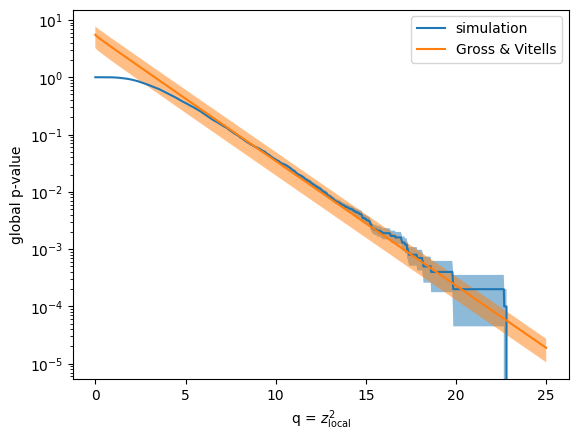

In [64]:
q_grid = np.linspace(0, 25, 1000)

p = [np.mean(q > qi) for qi in q_grid]
plt.plot(q_grid, p, label="simulation")

p_err = variance(lambda q: [np.mean(q > qi) for qi in q_grid], q) ** 0.5
plt.fill_between(q_grid, p - p_err, p + p_err, fc="C0", alpha=0.5)

p2, p2cov = propagate(
    lambda n: compute_p_global(q_grid**0.5, z_threshold, n),
    n_upcrossings, n_upcrossings, diagonal=True
)
p2err = p2cov ** 0.5
plt.plot(q_grid, p2, label="Gross & Vitells")
plt.fill_between(q_grid, p2 - p2err, p2 + p2err, fc="C1", alpha=0.5)
plt.semilogy()
plt.ylabel("global p-value")
plt.xlabel("q = $z_\\mathrm{local}^2$")
plt.legend();

## 2D case

In HEP, we often need to scan over more than just the mass, the natural width of the peak is also unknown unless the life-time of the particle can be measured as well.

In this toy example, I scan over the relative width from 0 % to 10 % of the mass of the particle. One could equally well implement a scan where the width is independent of the mass.

We already wrote the scan function for the 1D case so that it also works for the 2D case. It can be reused unmodified here.

In [65]:
m_grid = np.linspace(1200, 3800, 100)
rw_grid = np.linspace(0, 0.1, 20)

z = z_scan(data, m_grid, rw_grid)
z_local = np.max(z)
print(f"z_local = {z_local:.2f}")

z_local = 3.14


We find a local excess of $3.1\sigma$, higher than the previous local excess found when the relative width was fixed. This is expected, it is more likely to find a large local deviation if the scanned parameter space is larger.

Next, we visualize the result of the scan.

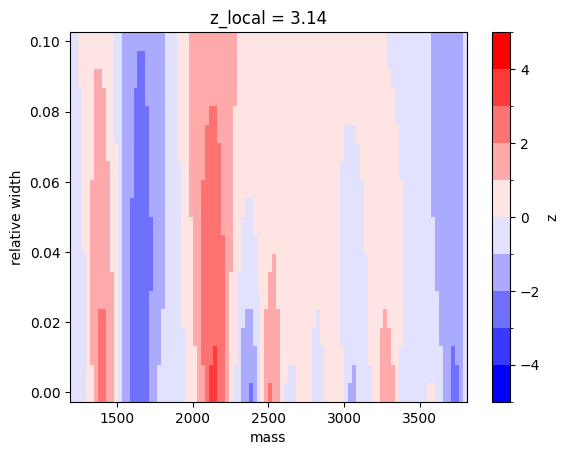

In [66]:
from matplotlib.colors import BoundaryNorm

cmap = plt.colormaps["bwr"]
norm = BoundaryNorm(np.linspace(-5, 5, 11), ncolors=cmap.N, clip=True)
plt.pcolormesh(m_grid, rw_grid, z.T, norm=norm, cmap=cmap)
plt.colorbar().set_label("z")
plt.title(f"z_local = {z_local:.2f}")
plt.xlabel("mass")
plt.ylabel("relative width");

To apply the Gross & Vitells formula for the 2D case, we again need to compute excursion sets. An excursion set is obtained as before: the p-value is computed from $q = z^2$ using the upper tail of the chi2(1) distribution, but the threshold probabilities are computed using the upper tail of a standard normal.

In a 2D plane, the excursions are counted differently. They are given by the number of locally connected excursions minus the number of holes. This difference is called the *Euler characteristic*.

Gross & Vitells describe a general algorithm to compute the Euler characteristic for any number of dimensions, which would take time to implement and test. Fortunately, I don't need to implement the algorithm for the 2D case, because an implementation can be found in the scikit-image Python library. This is a great time-saver.

Shown below are the excursion sets for $0\sigma$ and $1\sigma$ and the computed Euler characteristic for these two binary images.

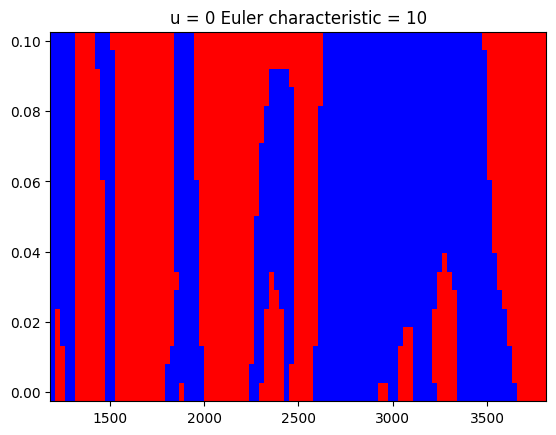

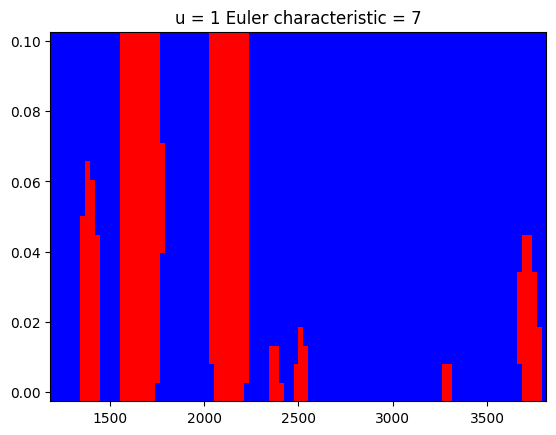

In [67]:
z_threshold = [0, 1]
euler_characteristic = []
for zt in z_threshold:
    excursions = chi2(1).sf(z**2) < z_to_pvalue(zt)
    ec = euler_number(excursions)  # euler_number is a misnomer by scikit-image
    euler_characteristic.append(ec)

    plt.figure()
    plt.pcolormesh(m_grid, rw_grid, excursions.T, cmap=cmap)
    plt.title(f"u = {zt} Euler characteristic = {ec}")

With these numbers we can again compute the extrapolation from local to global significance. We need to first solve a system of equations, for which one row is given by
$$
N[\phi_u] = 1/2 P(\chi^2 > u) + (\mathcal{N}_1 + \mathcal{N}_2 \sqrt{u}) e^{-u/2},
$$
where $N[\phi_u]$ is the expected Euler characteristic for excursions above $u = z_\mathrm{threshold}^2$, $P(\chi^2 > u)$ is the upper tail integral of a chi2(1) distribution, and $\mathcal{N}_1$, $\mathcal{N}_2$ are unknown parameters for which we solve the system, using the estimated values $N[\phi_u]$ for two chosen thresholds $u_0 = 0$ and $u_1 = 1$. The system is linear in $\mathcal{N}_1$ and $\mathcal{N}_2$ and the solution readily obtained with standard algorithms. Once $\mathcal{N}_1$ and $\mathcal{N}_2$ are given, we can use the same formula to compute the global p-value (equal to $N[\phi_u]$ for large $u$) from the local p-value (equal to $1/2 P(\chi^2 > u)$).


In [68]:
def compute_p_global(z_local, z_threshold, euler_characteristic):
    z_threshold = np.array(z_threshold)
    euler_characteristic = np.array(euler_characteristic)
    u = z_threshold ** 2
    p_chi2 = chi2(1).sf(u)

    # Solve system of linear equations
    # N[𝜙ᵤ] = 1/2 P(𝜒² > u) + (𝒩₁ + 𝒩₂ √𝑢) exp(−𝑢/2)
    # to get parameters 𝒩₁ and 𝒩₂.
    b = euler_characteristic - 0.5 * p_chi2
    f = np.exp(-u / 2)
    A = np.transpose((f, f * np.sqrt(u)))
    n1, n2 = np.linalg.solve(A, b)

    # We now apply
    # N[𝜙ᵤ] = 1/2 P(𝜒² > u) + (𝒩₁ + 𝒩₂ √𝑢) exp(−𝑢/2)
    # to the observed value of u = z_local^2.
    u = z_local**2
    f = np.exp(-u / 2)
    p_chi2 = chi2(1).sf(u)
    return 0.5 * p_chi2 + (n1 + n2 * np.sqrt(u)) * f


def compute_z_global(z_local, z_threshold, euler_characteristic):
    p_global = compute_p_global(z_local, z_threshold, euler_characteristic)
    return pvalue_to_z(p_global)


# Error propagation assumes that both Euler characteristics are 100% correlated.
# This is an approximation, but they must be strongly positively correlated.
z_global, z_global_cov = propagate(lambda n : compute_z_global(z_local, z_threshold, n),
                                   euler_characteristic, 
                                   [euler_characteristic, euler_characteristic])

print(f"z_local = {z_local:.2f}")
print(f"z_global = {z_global:.2f} +/- {z_global_cov ** 0.5:.2f}")

z_local = 3.14
z_global = 1.23 +/- 0.26


Next, we check this result again using simulations of independent experiments as in the previous case. The simulation takes a long time now since we need to perform a scan over 2D dimensions for each experiment.

In [69]:
# we cache this calculation, since it takes a while
cache_file = Path("q_samples_2d.pkl.gz")

if cache_file.exists():
    with gzip.open(cache_file) as f:
        q = pickle.load(f)
else:
    q = []

    seeds = 10000

    @delayed
    def run(iseed):
        mass = truncexpon.rvs(1000, 4000, 0, lambd_true, background_true, iseed)
        z = z_scan(mass, m_grid, rw_grid)
        return np.max(z**2)

    with Progress() as progress:
        q = Parallel(n_jobs=8)(run(iseed) for iseed in progress.track(range(seeds)))
    q = np.array(q)

    with gzip.open(cache_file, "w") as f:
        pickle.dump(q, f)

# check that all fits converged properly
np.mean(np.isnan(q))

0.0

We again visualize the distribution. As before, it approaches an exponential distribution for large $q$.

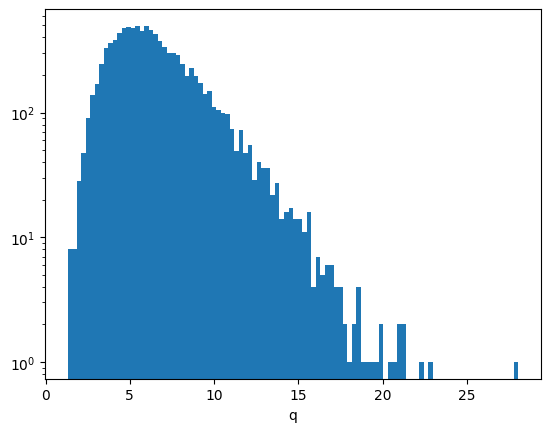

In [70]:
plt.hist(q, bins=100)
plt.semilogy()
plt.xlabel("q");

The simulation result is once again in excellent agreement.

In [71]:
p_global_sim = np.mean(q > z_local**2)
z_global_sim = pvalue_to_z(p_global_sim)

z_global_sim_cov = variance(lambda q: pvalue_to_z(np.mean(q > z_local**2)), q)
print(f"z_global_sim = {z_global_sim:.2f} +/- {z_global_sim_cov ** 0.5:.2f}")

z_global_sim = 1.25 +/- 0.02


We again plot the scan with the most extreme local significance. It is a positive excess this time.

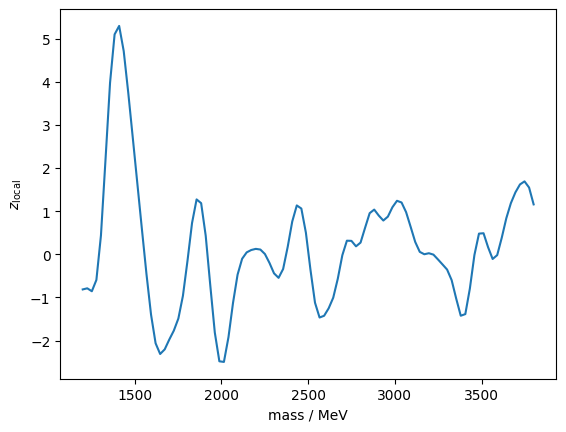

In [46]:
iseed = np.argmax(q)
mass = truncexpon.rvs(1000, 4000, 0, lambd_true, background_true, iseed)
z_m = []
for m in m_grid:
    z_m.append(fit(mass, m, rw_grid[0], fit_background(mass)[0]))
plt.plot(m_grid, [x[0] for x in z_m])
plt.ylabel("$z_\mathrm{local}$")
plt.xlabel("mass / MeV");

In [47]:
z_m[np.argmax([x[0] ** 2 for x in z_m])][1]

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 95.07 (χ²/ndof = 1.0)      │              Nfcn = 52               │
│ EDM = 3.11e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ signal     │    180    │    40     │            │            │         │         │       │
│ 1 │ mass       │  1.410e3  │  0.014e3  │            │            │         │         │  yes  │
│ 2 │ width      │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 3 │ background │  9.82e3   │  0.10e3   │            │            │    0    │         │       │
│ 4 │ lambd      │  2.05e3   │  0.05e3   │            │            │    0    │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬────────────────────────────────────────────────────────┐
│            │     signal       mass      width background      lambd │
├────────────┼────────────────────────────────────────────────────────┤
│     signal │   1.31e+03          0          0     -1.1e3      0.5e3 │
│       mass │          0          0          0          0          0 │
│      width │          0          0          0          0          0 │
│ background │     -1.1e3          0          0    1.1e+04     -0.5e3 │
│      lambd │      0.5e3          0          0     -0.5e3    2.9e+03 │
└────────────┴────────────────────────────────────────────────────────┘

As before, we compute the global p-value using simulation and with the Gross & Vitells formula for various q-values. The agreement is again very good above $q > 7$, which corresponds to about $2.6\sigma$.

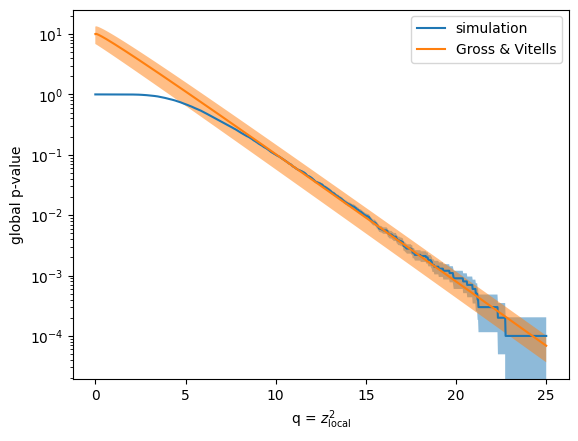

In [48]:
q_grid = np.linspace(0, 25, 1000)

p = [np.mean(q > qi) for qi in q_grid]
plt.plot(q_grid, p, label="simulation")

p_err = variance(lambda q: [np.mean(q > qi) for qi in q_grid], q) ** 0.5
plt.fill_between(q_grid, p - p_err, p + p_err, fc="C0", alpha=0.5)

# We assume 100% correlation for both values of the Euler characteristic.
p2, p2cov = propagate(
    lambda n: compute_p_global(q_grid**0.5, z_threshold, n),
    euler_characteristic,
    [euler_characteristic, euler_characteristic],
)
p2err = np.diag(p2cov) ** 0.5
plt.plot(q_grid, p2, label="Gross & Vitells")
plt.fill_between(q_grid, p2 - p2err, p2 + p2err, fc="C1", alpha=0.5)
plt.semilogy()
plt.ylabel("global p-value")
plt.xlabel("q = $z_\\mathrm{local}^2$")
plt.legend();

## Conclusion

I explored the application of the Gross & Vitells formulas for signal models with one or two nuisance parameters (apart from the amplitude), which extrapolate a local significance for a signal found in 1D or 2D scans to a global significance.

Using iminuit and numba-stats, I implemented a fast and robust fit for our example, which consists of a model that adds exponential background to a voigtian signal. The fits run fast and converge successfully every time, even though the total amount of individual fits is in the millions.

The Gross & Vitells formulas do not need my verification (they hold generally), but I needed to verified my implementation of them. As source material for my implementation I used the respective papers and slides presented by Eilam Gross at the ATLAS Stat Forum, 3/2010. The verification is based on a comparison to the result obtained with classical simulation. I found excellent agreement between both types of calculation.

To propagate statistical errors in each calculation, I used the jacobi and resample libraries, which implement numerical error propagation and the bootstrap method, respectively.

The second paper by Vitells & Gross and the slides also describe how the formulas can be further generalized to arbitrary dimensions. It should be easy to generalize my implementation for the 2D case to the 3D case, since the scikit-image algorithm to compute the Euler characteristic is also applicable to 3D sets, but I do not attempt this here. A generalization to even higher dimensions would require an implementation of the algorithm to compute the Euler characteristic in N dimensions.